### Accuracy Impacts of Using Augmented Data During Validation 

This notebook provides a close-up examination of the impact using augmented data during the validation phase of an epoch has on model performance.  

...

While the team's focus is on shrinking the distribution gap observed between the CIFAR 10 and 10.1 testsets, the results are examined from two dimensions:
  1. What, if any, effect is observed on the distribution gap when comparing model evaluations on an augemented CIFAR 10 testset to an augmented CIFAR 10.1 tesetset.
  2. What, if any, effect is observed in general model accuracy?
  
 

#### Install Libraries and Packages

In [1]:
import os
import re
import pandas as pd
from glob import glob
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)

#### Load the Data

In [2]:
search_path = "../model_results"
file_extension = "*.csv"

# Retrieve results from github directory
dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

# Convert the accuracy scores to percentages.
df = pd.concat(dfs, ignore_index=True)
df['Accuracy'] = df['Accuracy'].apply(lambda x: x*100)

# Get accuracy score of last epoch for each model type
df = df[df.groupby(['Model'])['Epoch'].transform(max) == df['Epoch']]

# Filter columns to those we need for analysis
df = df[['Model', 'Accuracy', 'Loss', 'Testset']].sort_values(by=['Model'])#

df['ra'] = df['Model'].str.contains("ra_")
df['val'] = df['Model'].str.contains("_c10val")
df['refined'] = df['Model'].str.contains("refined400")
df['cm'] = df['Model'].str.contains("cm")

# Filter out the CutMix results
df = df[df['cm']!=True]

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        M = int(srch3.group(2))
    return M

def chart_name(row):
    newname = ""
    if row['ra'] == False:
        newname = "Original Model"
    else:
        if row['refined'] == True :
            newname += "Train: RA N=" + str(row['N']) + ",M=" + str(row['M']) + " + Unaugmented Refine"
        else:
            newname += "Train: RA N=" + str(row['N']) + ",M=" + str(row['M']) 

        if row['val'] == True:
            newname += "; Val: Unaugmented"
        else:
            newname += "; Val: Augmented"        
    return newname
    
df['N'] = df.apply(lambda row: ra_N_extraction(row), axis=1)
df['M'] = df.apply(lambda row: ra_M_extraction(row), axis=1)
df['ChartName'] = df.apply(lambda row: chart_name(row), axis=1)
cols = ['N', 'M']
df['hue'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#### Functions

In [3]:
def compare_results(mydf):
    df_dnet2 = mydf[mydf['ra']==True]
    df_dnet2 = df_dnet2[["val", "ra", "refined", "N", "M", "Accuracy", "Testset"]]

    s = df_dnet2.groupby(['ra', 'N', 'M', "refined", "Testset"]).cumcount()

    df1 = df_dnet2.set_index(['ra', 'N', 'M', "refined", "Testset", s]).unstack().sort_index(level=1, axis=1)
    df1.columns = [f'{x}{y}' for x, y in df1.columns]
    df1 = df1.rename(columns={"Accuracy0": "Accuracy_Augmented_Val", "Accuracy1": "Accuracy_Unaugmented_Val"})
    df1.drop(columns=['val0', 'val1'], inplace=True)
    df1["Delta_Accuracy"] = (df1["Accuracy_Augmented_Val"] - df1["Accuracy_Unaugmented_Val"]).abs()
    df1["Unaugmented_HigherAcc"] =  df1["Accuracy_Augmented_Val"] < df1["Accuracy_Unaugmented_Val"]
    return df1

def plot_acc_results(model_name, mydf):
    flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#003262", "#859438",  "#C4820E"]

    f, ax = plt.subplots(figsize=(18, 6))
    sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=mydf[mydf['Testset'] == 'cifar10'], 
                       markers=['D'] * 5, linestyles=['-']*5, palette=flatui, ci=None)  
    plt.xlabel('Validation Data Type', fontsize=13)
    plt.ylabel('Accuracy', fontsize=13)
    plt.title(model_name + ': Impacts to Accuracy When Using Augmented Data During Validation', fontsize=16)
    plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
    sns.set_style()

    sp = sns.pointplot(x="ChartName", hue="hue", y="Accuracy", data=mydf[mydf['Testset'] == 'cifar10.1'], 
                       markers=['o']*5, linestyles=['--']*5, palette=flatui, ci=None,alpha=0.7)

    # train_datasets = ['CIFAR 10', 'CIFAR10 RandAugment N=2,M=20', 'CIFAR10 RandAugment N=2,M=5', 'CIFAR10 RandAugment N=3,M=20']
    # test_datasets = ['CIFAR 10', 'CIFAR 10.1']

    # h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
    # leg = ax.legend(handles=h, labels=train_datasets,loc=(.005,.01), title="Training Dataset by Color")
    # ax.add_artist(leg)

    # h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
    # ax.legend(handles=h2, labels=train_datasets,loc=(.22,0.01), title="Test Dataset by Marker")

def c10_c101_diff(mydf):
    df_val_cifar10 = mydf[mydf.Testset == 'cifar10'][['Unaugmented_HigherAcc']].apply(pd.value_counts)
    df_val_cifar101 = mydf[mydf.Testset == 'cifar10.1'][['Unaugmented_HigherAcc']].apply(pd.value_counts)
    df_val_cifar101.sort_index(inplace=True)
    df_val_cifar10.sort_index(inplace=True)
    outcomes = df_val_cifar10.join(df_val_cifar101, lsuffix="CIFAR10", rsuffix="CIFAR10.1")
    outcomes.columns = outcomes.columns.str.lstrip("Unaugmented_HigherAcc")
    outcomes.plot.barh()
    plt.legend(fancybox=True, loc='center right', borderpad=1)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('', fontsize=11)
    plt.title('Did Validation with Unaugmented Data\n Improve Prediction Accuracy on the Testset?')   

### Densenet

In [81]:
# Filter the results to focus on densenet, the model the experiment was run on.
df_dnet = df[df["Model"].str.contains('densenet')]

#### Results Analysis

In [82]:
df_dnet1 = compare_results(df_dnet)
df_dnet1

Accuracy_Augmented_Val  Accuracy_Unaugmented_Val  \
ra   N M  refined Testset                                                       
True 2 5  False   cifar10                     89.52                     89.07   
                  cifar10.1                   77.10                     77.70   
          True    cifar10                     93.13                     93.21   
                  cifar10.1                   84.70                     85.70   
       20 False   cifar10                     79.00                     81.54   
                  cifar10.1                   63.90                     68.15   
          True    cifar10                     91.68                     91.23   
                  cifar10.1                   82.90                     83.15   
     3 20 False   cifar10                     71.15                     67.69   
                  cifar10.1                   57.95                     54.80   
          True    cifar10                     90.76                     90.24   
                  cifar10.1                   80.95                     81.35   

                             Delta_Accuracy  Unaugmented_HigherAcc  
ra   N M  refined Testset                                           
True 2 5  False   cifar10              0.45                  False  
                  cifar10.1            0.60                   True  
          True    cifar10              0.08                   True  
                  cifar10.1            1.00                   True  
       20 False   cifar10              2.54                   True  
                  cifar10.1            4.25                   True  
          True    cifar10              0.45                  False  
                  cifar10.1            0.25                   True  
     3 20 False   cifar10              3.46                  False  
                  cifar10.1            3.15                  False  
          True    cifar10              0.52                  False  
                  cifar10.1            0.40                   True

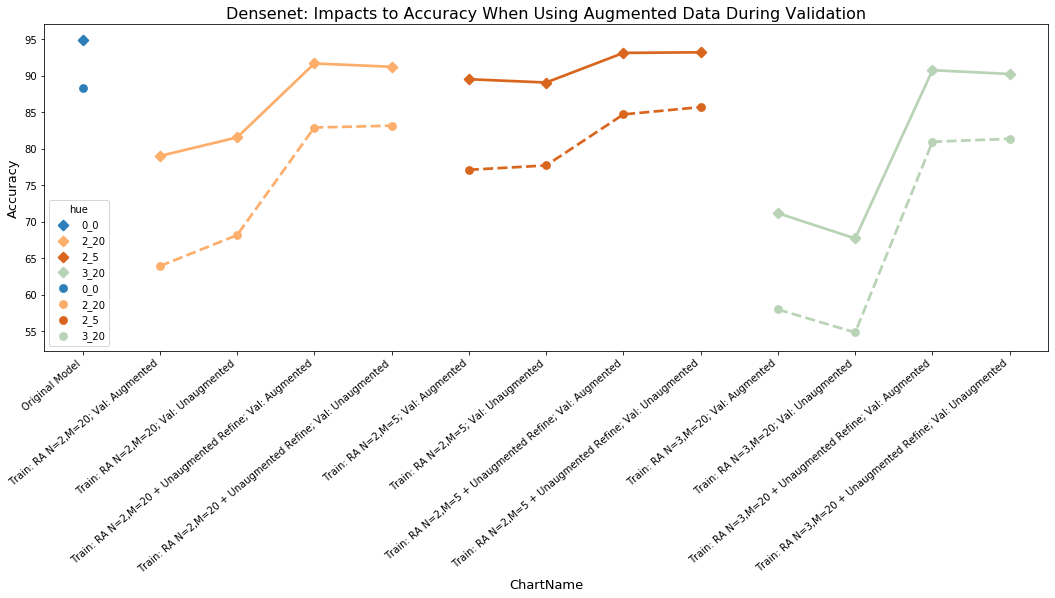

In [84]:
plot_acc_results("Densenet", df_dnet)

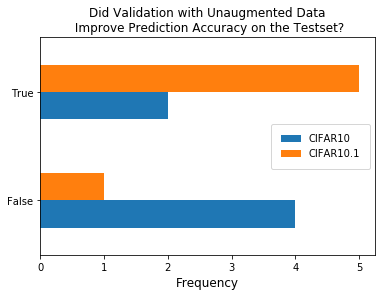

In [85]:
c10_c101_diff(df_dnet1.reset_index())

Observations:
  - Accuracy on CIFAR 10.1 more generally improved when validation occurred with unaugmented data
  - Refining on unaugmented data reduces the performance delta observed.
  

### Resnet 32

In [86]:
# Filter the results to focus on resnet, the model the experiment was run on.
df_resnet = df[df["Model"].str.contains('resnet_basic_32')]
df_resnet = df_resnet[~df_resnet["Model"].str.contains('refined300')]

df_resnet1 = compare_results(df_resnet)
df_resnet1

Accuracy_Augmented_Val  Accuracy_Unaugmented_Val  \
ra   N M  refined Testset                                                       
True 1 20 False   cifar10                     82.26                     79.45   
                  cifar10.1                   69.75                     66.15   
          True    cifar10                     89.28                     88.97   
                  cifar10.1                   78.50                     80.05   
     2 5  False   cifar10                     81.48                     81.84   
                  cifar10.1                   67.80                     69.75   
          True    cifar10                     88.23                     87.66   
                  cifar10.1                   78.55                     77.90   
       20 False   cifar10                     72.41                     71.27   
                  cifar10.1                   52.30                     58.55   
          True    cifar10                     86.93                     86.70   
                  cifar10.1                   76.90                     76.45   
     3 20 False   cifar10                     45.87                     57.00   
                  cifar10.1                   31.85                     44.05   
          True    cifar10                     85.05                     85.46   
                  cifar10.1                   74.20                     74.10   

                             Delta_Accuracy  Unaugmented_HigherAcc  
ra   N M  refined Testset                                           
True 1 20 False   cifar10              2.81                  False  
                  cifar10.1            3.60                  False  
          True    cifar10              0.31                  False  
                  cifar10.1            1.55                   True  
     2 5  False   cifar10              0.36                   True  
                  cifar10.1            1.95                   True  
          True    cifar10              0.57                  False  
                  cifar10.1            0.65                  False  
       20 False   cifar10              1.14                  False  
                  cifar10.1            6.25                   True  
          True    cifar10              0.23                  False  
                  cifar10.1            0.45                  False  
     3 20 False   cifar10             11.13                   True  
                  cifar10.1           12.20                   True  
          True    cifar10              0.41                   True  
                  cifar10.1            0.10                  False

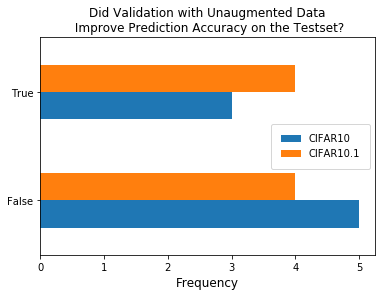

In [87]:
c10_c101_diff(df_resnet1.reset_index())

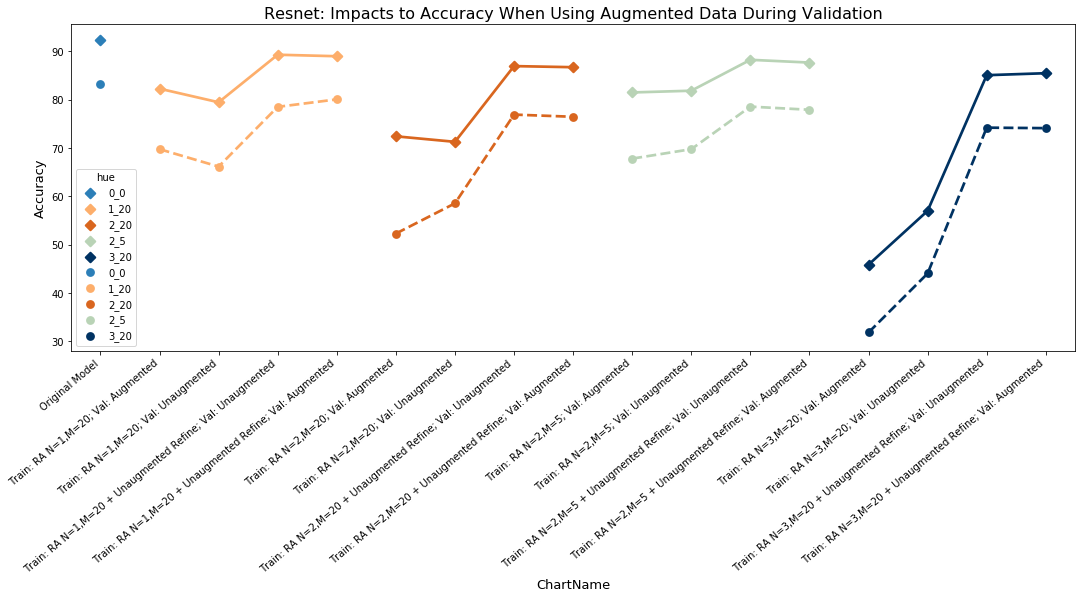

In [88]:
plot_acc_results("Resnet", df_resnet)

### WRN

In [7]:
# Filter the results to focus on WRN, the model the experiment was run on.
df_wrn = df[df["Model"].str.contains('wrn_28_10')]
df_wrn = df_wrn[~df_wrn["Model"].str.contains('refined300')]

df_wrn1 = compare_results(df_wrn)
df_wrn1

Accuracy_Augmented_Val  Accuracy_Unaugmented_Val  \
ra   N M  refined Testset                                                       
True 1 20 False   cifar10                     90.57                       NaN   
                  cifar10.1                   82.20                       NaN   
          True    cifar10                     94.30                       NaN   
                  cifar10.1                   87.55                       NaN   
     2 5  False   cifar10                     91.19                     91.09   
                  cifar10.1                   81.45                     81.80   
          True    cifar10                     93.76                     94.03   
                  cifar10.1                   86.00                     85.20   
       20 False   cifar10                     83.37                     84.56   
                  cifar10.1                   69.40                     73.65   
          True    cifar10                     93.33                     93.15   
                  cifar10.1                   85.25                     84.70   
     3 20 False   cifar10                     75.99                     75.38   
                  cifar10.1                   62.90                     62.85   
          True    cifar10                     92.04                     90.01   
                  cifar10.1                   84.15                     79.80   

                             Delta_Accuracy  Unaugmented_HigherAcc  
ra   N M  refined Testset                                           
True 1 20 False   cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
          True    cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
     2 5  False   cifar10              0.10                  False  
                  cifar10.1            0.35                   True  
          True    cifar10              0.27                   True  
                  cifar10.1            0.80                  False  
       20 False   cifar10              1.19                   True  
                  cifar10.1            4.25                   True  
          True    cifar10              0.18                  False  
                  cifar10.1            0.55                  False  
     3 20 False   cifar10              0.61                  False  
                  cifar10.1            0.05                  False  
          True    cifar10              2.03                  False  
                  cifar10.1            4.35                  False

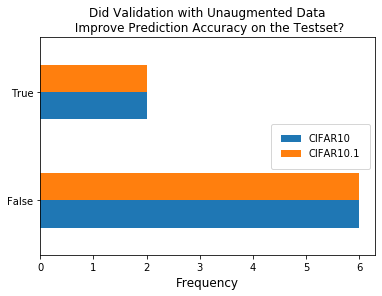

In [8]:
c10_c101_diff(df_wrn1.reset_index())

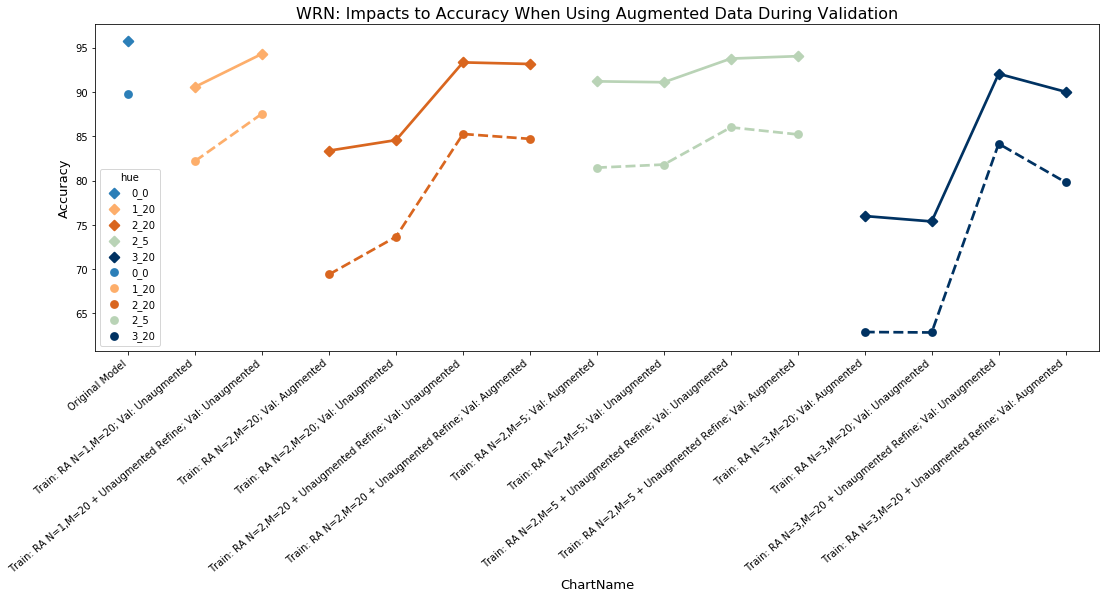

In [9]:
plot_acc_results("WRN", df_wrn)

### Resnext

In [14]:
df_resnext

,Model,Accuracy,Loss,Testset,ra,val,refined,cm,N,M,ChartName,hue
125,resnext_29_4x64d,89.05,0.3742,cifar10.1,False,False,False,False,0,0,Original Model,0_0
124,resnext_29_4x64d,95.35,0.1517,cifar10,False,False,False,False,0,0,Original Model,0_0
91,resnext_29_4x64d_ra_1_20_c10val,73.90,0.8678,cifar10.1,True,True,False,False,1,20,"Train: RA N=1,M=20; Val: Unaugmented",1_20
90,resnext_29_4x64d_ra_1_20_c10val,86.27,0.4583,cifar10,True,True,False,False,1,20,"Train: RA N=1,M=20; Val: Unaugmented",1_20
93,resnext_29_4x64d_ra_1_20_c10val_refined400,93.67,0.2095,cifar10,True,True,True,False,1,20,"Train: RA N=1,M=20 + Unaugmented Refine; Val: ...",1_20
92,resnext_29_4x64d_ra_1_20_c10val_refined400,85.65,0.4877,cifar10.1,True,True,True,False,1,20,"Train: RA N=1,M=20 + Unaugmented Refine; Val: ...",1_20
10,resnext_29_4x64d_ra_2_20,78.95,0.7273,cifar10,True,False,False,False,2,20,"Train: RA N=2,M=20; Val: Augmented",2_20
11,resnext_29_4x64d_ra_2_20,63.80,1.2738,cifar10.1,True,False,False,False,2,20,"Train: RA N=2,M=20; Val: Augmented",2_20
107,resnext_29_4x64d_ra_2_20_c10val,66.60,1.2357,cifar10.1,True,True,False,False,2,20,"Train: RA N=2,M=20; Val: Unaugmented",2_20
106,resnext_29_4x64d_ra_2_20_c10val,80.27,0.6940,cifar10,True,True,False,False,2,20,"Train: RA N=2,M=20; Val: Unaugmented",2_20


In [15]:
# Filter the results to focus on WRN, the model the experiment was run on.
df_resnext = df[df["Model"].str.contains('resnext_29_4x64')]
#df_resnext = df_resnext[~df_resnext["Model"].str.contains('refined300')]

df_resnext1 = compare_results(df_resnext)
df_resnext1

Accuracy_Augmented_Val  Accuracy_Unaugmented_Val  \
ra   N M  refined Testset                                                       
True 1 20 False   cifar10                     86.27                       NaN   
                  cifar10.1                   73.90                       NaN   
          True    cifar10                     93.67                       NaN   
                  cifar10.1                   85.65                       NaN   
     2 5  False   cifar10                     88.57                       NaN   
                  cifar10.1                   77.55                       NaN   
          True    cifar10                     93.54                       NaN   
                  cifar10.1                   84.55                       NaN   
       20 False   cifar10                     78.95                     80.27   
                  cifar10.1                   63.80                     66.60   
          True    cifar10                     92.33                     92.60   
                  cifar10.1                   83.90                     85.05   
     3 20 False   cifar10                     72.41                       NaN   
                  cifar10.1                   49.35                       NaN   
          True    cifar10                     90.18                       NaN   
                  cifar10.1                   81.85                       NaN   

                             Delta_Accuracy  Unaugmented_HigherAcc  
ra   N M  refined Testset                                           
True 1 20 False   cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
          True    cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
     2 5  False   cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
          True    cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
       20 False   cifar10              1.32                   True  
                  cifar10.1            2.80                   True  
          True    cifar10              0.27                   True  
                  cifar10.1            1.15                   True  
     3 20 False   cifar10               NaN                  False  
                  cifar10.1             NaN                  False  
          True    cifar10               NaN                  False  
                  cifar10.1             NaN                  False

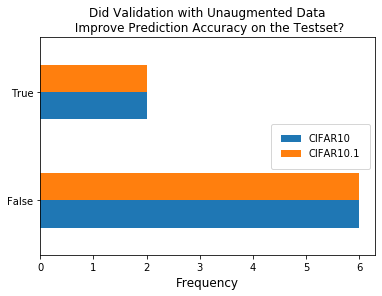

In [16]:
c10_c101_diff(df_resnext1.reset_index())

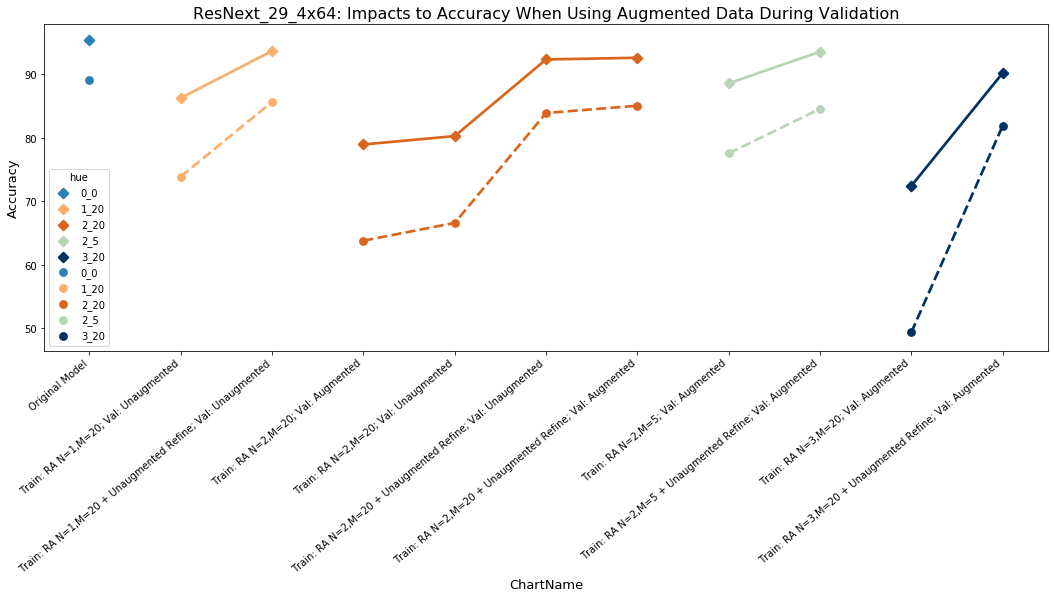

In [13]:
plot_acc_results("ResNext_29_4x64", df_resnext)